In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:

image_size=256
batch_size=32
channel=3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_Signature_Finals",
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 720 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['forge', 'real']

In [8]:
len(dataset)

23

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]], shape=(256, 256, 3), dtype=float32)


In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


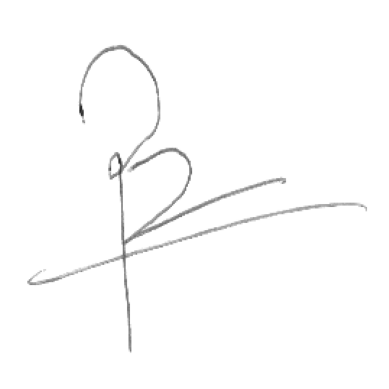

In [12]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')

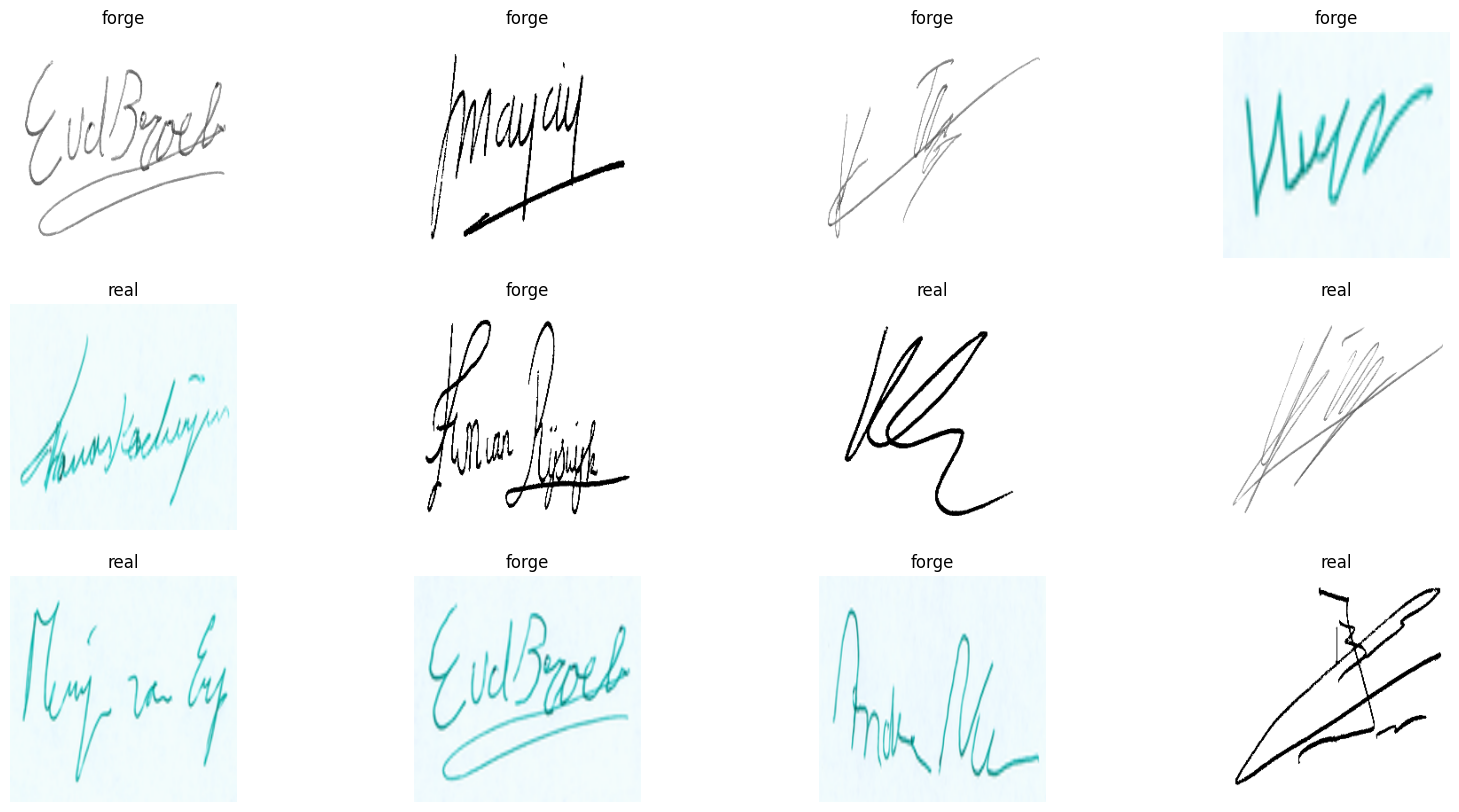

In [13]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):  # Take one batch of images
    for i in range(12):  # Display 12 images
        ax = plt.subplot(3, 4, i + 1)  # Create subplot
        plt.imshow(image_batch[i].numpy().astype('uint8'))  # Display image
        plt.title(class_names[label_batch[i]])  # Title based on label
        plt.axis('off')  # Turn off axes
		

In [14]:
len(dataset)

23

In [15]:
train_size = 0.8
len(dataset)*train_size

18.400000000000002

In [16]:
def getdataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=getdataset_partition(dataset)

In [18]:
len(train_ds)

18

In [19]:
len(val_ds)

2

In [20]:
len(test_ds)

3

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
class ResizeRescaleLayer(layers.Layer):
    def __init__(self, image_size):
        super(ResizeRescaleLayer, self).__init__()
        self.image_size = image_size

    def call(self, inputs):
        inputs = tf.image.resize(inputs, [self.image_size, self.image_size])
        return inputs / 255.0

    def get_config(self):
        config = super().get_config()
        config.update({"image_size": self.image_size})
        return config

In [23]:
# Data augmentation layer using tf.image functions
class DataAugmentationLayer(layers.Layer):
    def __init__(self):
        super(DataAugmentationLayer, self).__init__()

    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.random_flip_left_right(inputs)
            inputs = tf.image.random_flip_up_down(inputs)
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))  # random 90-degree rotation
        return inputs

data_augmentation = DataAugmentationLayer()

In [24]:
input_shape = (image_size, image_size, channel)
n_classes = len(class_names)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),   # Explicitly add an InputLayer
    ResizeRescaleLayer(image_size),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


In [25]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_rescale_layer (Resize (None, 256, 256, 3)       0         
_________________________________________________________________
data_augmentation_layer (Dat (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        3

In [27]:
model.save('crnn_signature_verification_model1.keras')

In [28]:
history = model.fit(
train_ds,
epochs=50,
batch_size=batch_size,
verbose=1,
validation_data=val_ds
)

Epoch 1/50
18/18 [==============================] - 30s 1s/step - loss: 0.7805 - accuracy: 0.5300 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
18/18 [==============================] - 17s 940ms/step - loss: 0.6922 - accuracy: 0.5312 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 3/50
18/18 [==============================] - 19s 1s/step - loss: 0.6938 - accuracy: 0.5139 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/50
18/18 [==============================] - 23s 1s/step - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/50
18/18 [==============================] - 24s 1s/step - loss: 0.6931 - accuracy: 0.4885 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/50
18/18 [==============================] - 23s 1s/step - loss: 0.6926 - accuracy: 0.5022 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 7/50
18/18 [==============================] - 24s 1s/step - loss: 0.6918 - accuracy: 0.5240 - val_loss: 0.6899 - val_accuracy: 0.5469
Epoch 8/50
18/18 

In [29]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 5s 155ms/step - loss: 1.9665 - accuracy: 0.5625


In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 18}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.5035714507102966,
 0.4982142746448517,
 0.48750001192092896,
 0.5017856955528259,
 0.5017856955528259,
 0.5017856955528259,
 0.4982142746448517,
 0.5482142567634583,
 0.5696428418159485,
 0.6142857074737549,
 0.6321428418159485,
 0.6392857432365417,
 0.6357142925262451,
 0.6660714149475098,
 0.7142857313156128,
 0.6964285969734192,
 0.7303571701049805,
 0.7821428775787354,
 0.8321428298950195,
 0.8857142925262451,
 0.8910714387893677,
 0.9196428656578064,
 0.9428571462631226,
 0.9767857193946838,
 0.9696428775787354,
 0.9785714149475098,
 0.9821428656578064,
 0.9839285612106323,
 0.9839285612106323,
 0.9946428537368774,
 0.9892857074737549,
 0.9910714030265808,
 0.9857142567634583,
 0.987500011920929,
 0.987500011920929,
 0.9857142567634583,
 0.987500011920929,
 0.9892857074737549,
 0.9964285492897034,
 0.9964285492897034,
 1.0,
 1.0,
 0.9982143044471741,
 0.9892857074737549,
 0.9946428537368774,
 0.9946428537368774,
 0.9910714030265808,
 1.0,
 0.9964285492897034,
 0.998214304447174

In [33]:
acc_his = history.history['accuracy']
val_acc_his = history.history['val_accuracy']
loss_his = history.history['loss']
val_loss_his = history.history['val_loss']

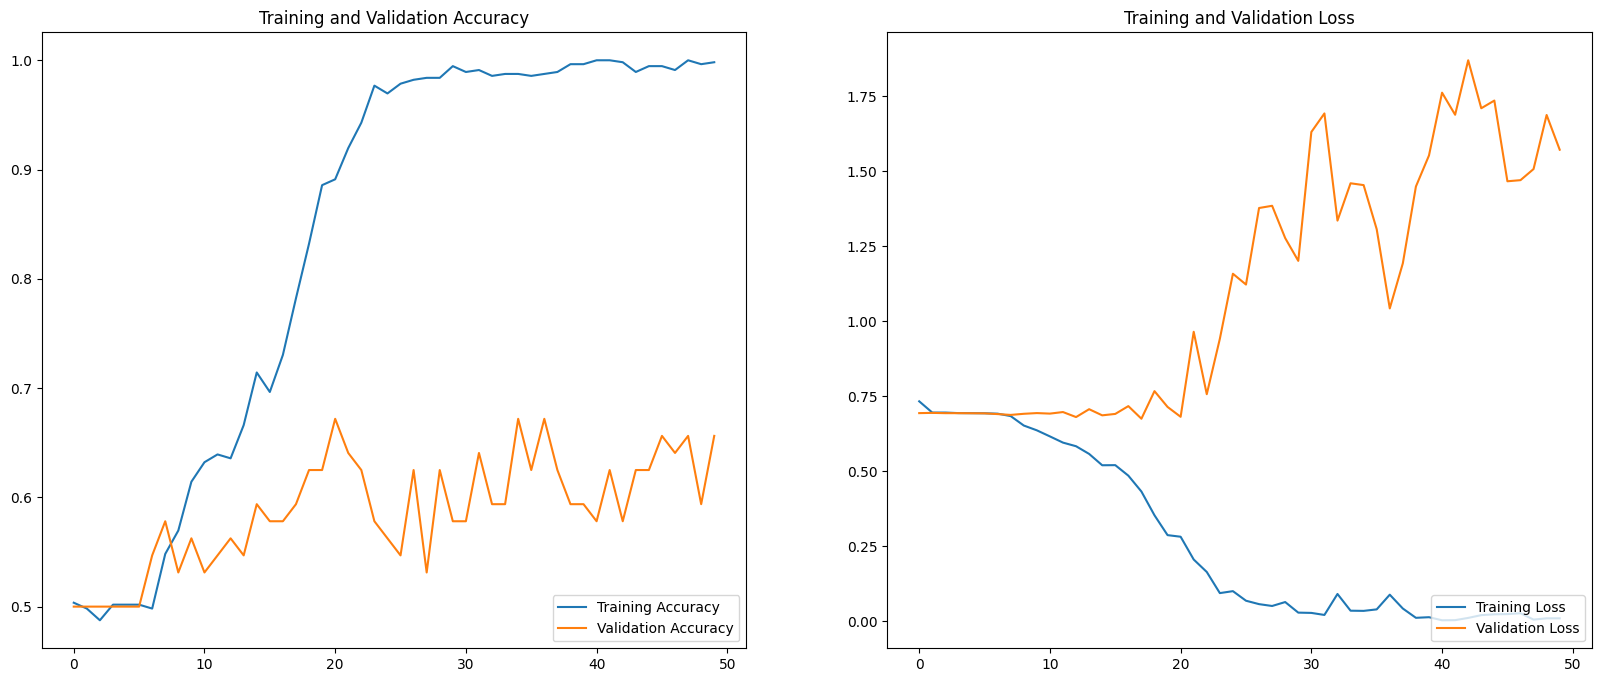

In [34]:
plt.figure(figsize=(20,8))
ax = plt.subplot(1,2,1)
plt.plot(range(50),acc_his,label='Training Accuracy')
plt.plot(range(50),val_acc_his,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
ax = plt.subplot(1,2,2)
plt.plot(range(50),loss_his,label='Training Loss')
plt.plot(range(50),val_loss_his,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: forge
predicted label: forge


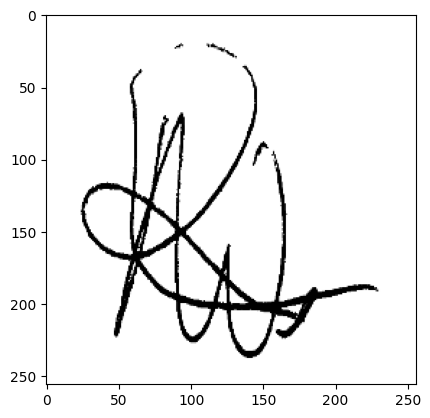

In [35]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label:',class_names[first_label])
    batch_predictions=model.predict(image_batch)
    print('predicted label:',class_names[np.argmax(batch_predictions[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Use 'img' instead of 'images[i]'
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]  # Use [] instead of ()
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

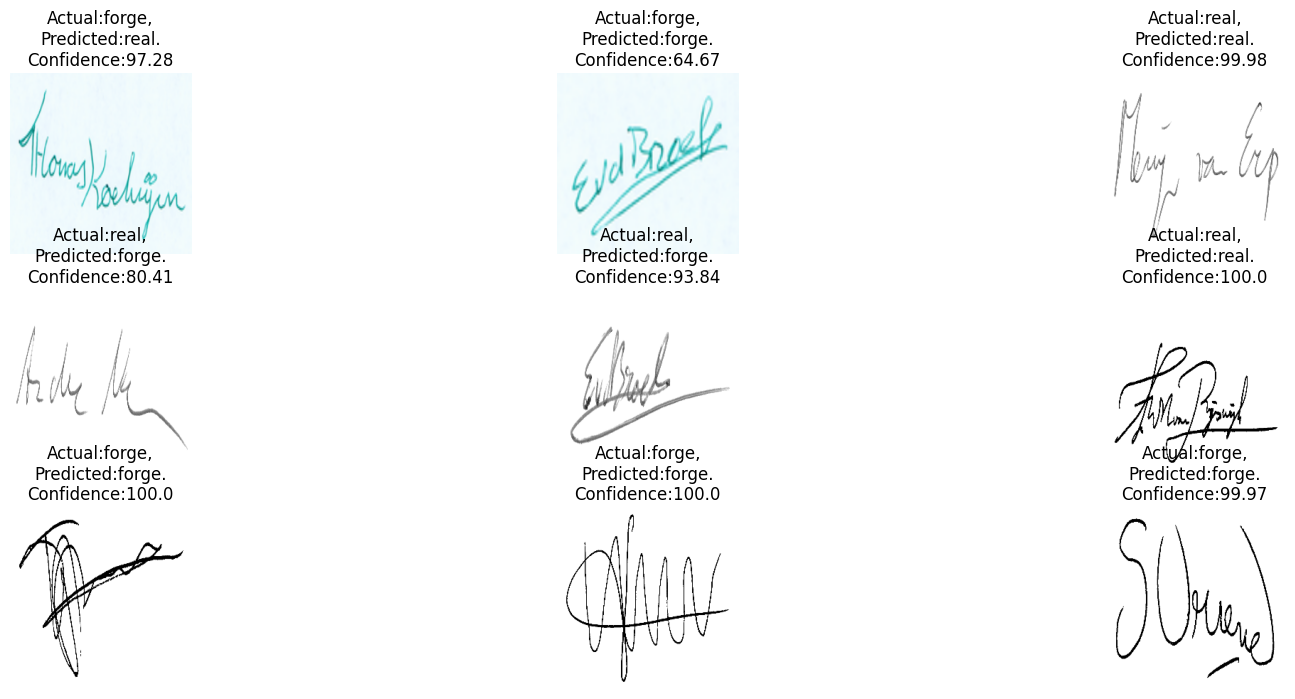

In [37]:
plt.figure(figsize=(20,8))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence= predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual:{actual_class},\nPredicted:{predicted_class}.\nConfidence:{confidence}')
        plt.axis('off')

In [38]:
final_loss,final_accuracy=model.evaluate(test_ds)
print('Final loss:{:.2f}%'.format(final_loss*100))
print('Final Accuracy:{:.2f}%'.format(final_accuracy*100))

3/3 [==============================] - 1s 158ms/step - loss: 1.9665 - accuracy: 0.5625
Final loss:196.65%
Final Accuracy:56.25%
